In [2]:
from qiskit import IBMQ, pulse, schedule
from qiskit.circuit import QuantumCircuit, Gate, Parameter
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
IBMQ.load_account() # load if no backend satisfies
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_oslo')
qubit = 0
backend_config = backend.configuration()
dt = backend_config.dt  
backend_defaults = backend.defaults()

In [4]:
f01 = 4925170000.0
f12 = 4581552617.648945

d12_duration = 544
d12_amplitude = 0.10879003883868105
d12_sigma = 40

d01_duration = 544
d01_sigma = 67
d01_amplitude = 0.07999888439750123

# The X and Y gates from field control

## Just another $X_{\pi}^{(01)}$ pulse.

Just a simple rabi oscillation between $E_{|0\rangle}$ and $E_{|1\rangle}$ energy levels. 

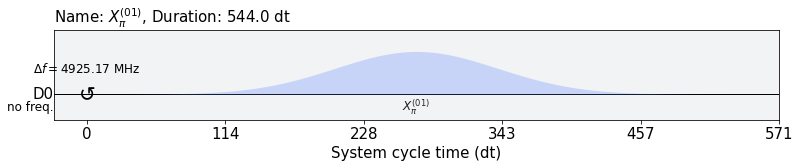

In [4]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$') as inst_xpi01:
    drive_duration = d01_duration
    drive_sigma = d01_sigma
    pi_amp = d01_amplitude
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                                  amp=pi_amp,
                                  sigma=drive_sigma,
                                  name=r'$X_{\pi}^{(01)}$'), drive_chan)

inst_xpi01.draw()

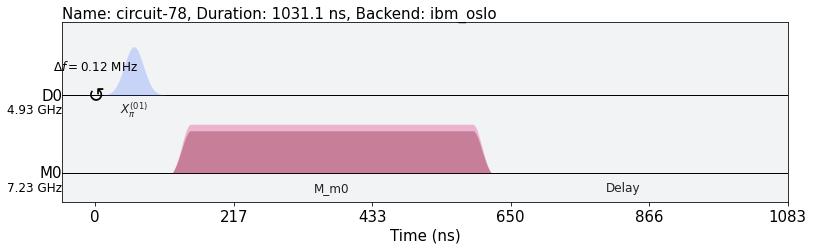

In [5]:
qc = QuantumCircuit(1,1)

xp01 = Gate(r'X_pi^01', 1, [])

qc.append(xp01, [0])
qc.measure(0,0)
qc.add_calibration(xp01, (0,), inst_xpi01, [])

sched = schedule(qc, backend)
sched.draw(backend=backend)

In [26]:
num_shots = 1024

job = backend.run(qc, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


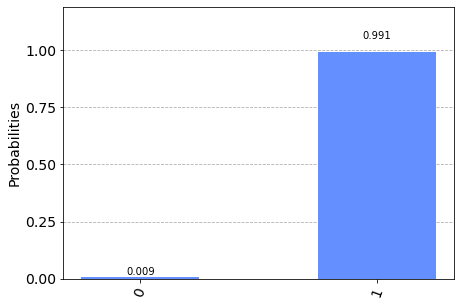

In [30]:
counts = job.result().get_counts()
plot_histogram(counts)

## Just another $X^{(01)}_{\pi/2}$ pulse.

Using the fact that $\Omega_{\theta}=\Omega_{\pi}\left(\dfrac{\theta}{\pi}\right)$

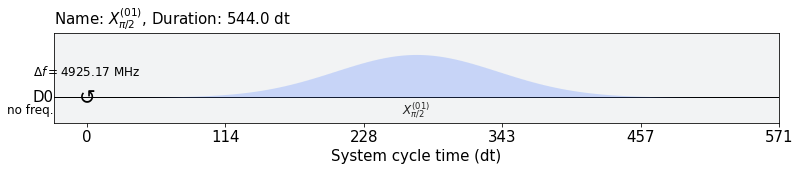

In [6]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi/2}^{(01)}$') as inst_xpio201:
    drive_duration = d01_duration
    drive_sigma = d01_sigma
    pi_amp = d01_amplitude
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                                  amp=pi_amp/2,
                                  sigma=drive_sigma,
                                  name=r'$X_{\pi/2}^{(01)}$'), drive_chan)

inst_xpio201.draw()

In [7]:
qc = QuantumCircuit(1,1)

xpio2 = Gate(r'X_pi/2^01', 1, [])
qc.append(xpio2, [0])
qc.measure(0,0)
qc.add_calibration(xpio2, (0,), inst_xpio2, [])

sched = schedule(qc, backend)
sched.draw(backend=backend)

NameError: name 'inst_xpio2' is not defined

In [49]:
num_shots = 2**13

job = backend.run(qc, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots)

job_monitor(job)

KeyboardInterrupt: 

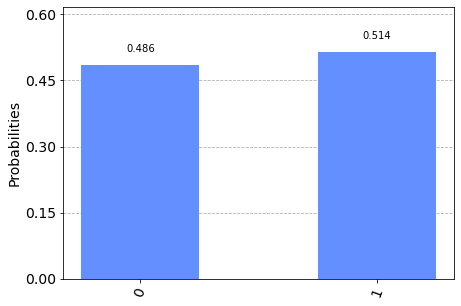

In [37]:
counts = job.result().get_counts()
plot_histogram(counts)

## Here comes $Y_\theta^{(01)}$ pulse

Given that an arbitrary pulse on superconducting qutrit's (mn) subspace is specified by 

\begin{align}
U = \exp\left[-i\dfrac{\theta}{2}\left(\cos(\phi)\lambda_x^{(mn)}+\sin(\phi)\lambda_y^{(mn)}\right)\right]
\end{align}

where the generators of rotation are the Gell-Mann matrices specified [here](https://github.com/ngdnhtien/PulsatingPulseLab/blob/main/exp_gell.ipynb). It is straightforward that if $\phi=\pi/2$, then the pulse's equivalent unitary becomes

\begin{align}
U &= \exp\left[-i\dfrac{\theta}{2}\left(\cos(\pi/2)\lambda_x^{(mn)}+\sin(\pi/2)\lambda_y^{(mn)}\right)\right]\\
&= \exp\left(-i\dfrac{\theta}{2}\lambda_y^{(mn)}\right)
\end{align}

Choosing $(mn)$ to be $(01)$, if starting from $|0\rangle$, then the result of the rotation shall be $|1\rangle$ (logical gate, error-free).

First have a nice mathematical observation that: $Z^{(01)}_{\pi/2}\cdot X^{(01)}_{\theta}\cdot Z^{(01)}_{-\pi/2} = Y_{\pi}^{(01)}$. What does it mean? It means that if sandwiching any X-rotation by a pair of Z can effectively generate a Y-rotation. This has a nice geometrical intepretation, and a deep connection with the concepts of frame and other important stuff. Now, we know precisely what does **choose** means--we add a *PhaseOffset* of value $\pi/2$ to a pulse (which represent a Rabi oscillation of period $\pi$), and *voila*, here comes $Y_\theta^{(01)}$ pulse!

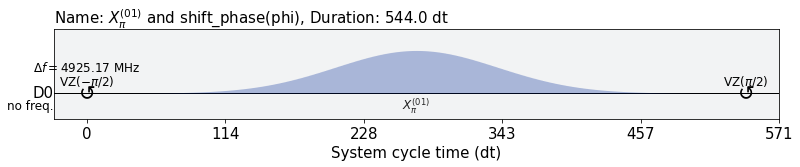

In [8]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$ and shift_phase(phi)') as inst_ypi01:
    drive_duration = d01_duration
    drive_sigma = d01_sigma
    pi_amp = d01_amplitude
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(np.pi/2, drive_chan):
        pulse.play(pulse.Gaussian(duration=drive_duration,
                                      amp=pi_amp,
                                      sigma=drive_sigma,
                                      name=r'$X_{\pi}^{(01)}$'), drive_chan)

inst_ypi01.draw()

In [9]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\pi}^{(01)}$ and shift_phase(phi)') as inst_ytheta01:
    drive_duration = d01_duration
    drive_sigma = d01_sigma
    pi_amp = d01_amplitude
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(np.pi/2, drive_chan):
        pulse.play(pulse.Gaussian(duration=drive_duration,
                                      amp=(theta/np.pi)*pi_amp,
                                      sigma=drive_sigma,
                                      name=r'$X_{\pi}^{(01)}$'), drive_chan)

inst_ytheta01.draw()

NameError: name 'theta' is not defined

In [10]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$Y_{\theta}^{(01)}$') as inst_z_ytheta01_z:
    drive_duration = d01_duration
    drive_sigma = d01_sigma
    pi_amp = d01_amplitude
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(3, drive_chan):
        with pulse.phase_offset(np.pi/2, drive_chan):
            pulse.play(pulse.Gaussian(duration=drive_duration,
                                          amp=(theta/np.pi)*pi_amp,
                                          sigma=drive_sigma,
                                          name=r'$Y_{\theta}^{(01)}$'), drive_chan)

inst_z_ytheta01_z.draw()

NameError: name 'theta' is not defined

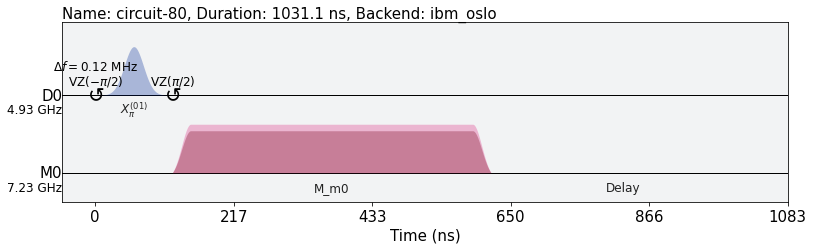

In [11]:
qc = QuantumCircuit(1,1)

yp01 = Gate('Yp01', 1, [])

qc.append(yp01, [0])
qc.measure(0,0)

qc.add_calibration(yp01, (0,), inst_ypi01, [])

sched = schedule(qc, backend)
sched.draw(backend=backend)

In [52]:
num_shots = 2**13

job = backend.run(qc, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


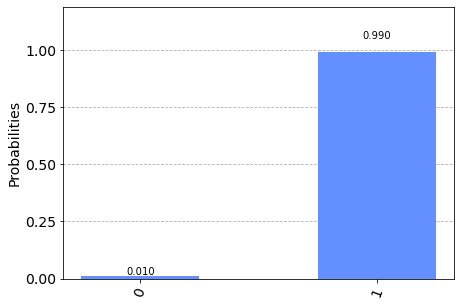

In [53]:
counts = job.result().get_counts()
plot_histogram(counts)

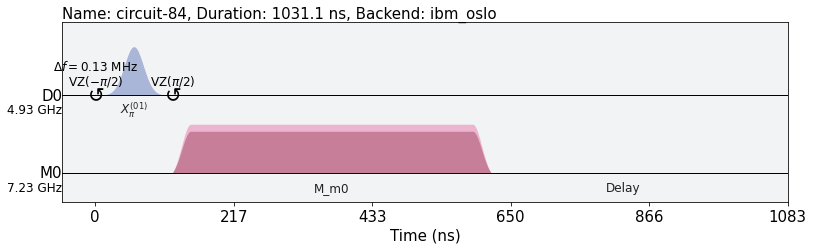

In [15]:
qc = QuantumCircuit(1,1)

y_po = Gate(r'Y_phase_offset', 1, [])
y_sp = Gate(r'Y_shift_phase', 1, [])

qc.append(y_sp, [0])
qc.measure(0,0)

qc.add_calibration(y_sp, (0,), inst_ypi01, [])

sched = schedule(qc, backend)
sched.draw(backend=backend)

In [15]:
num_shots = 2**13

job = backend.run(qc, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


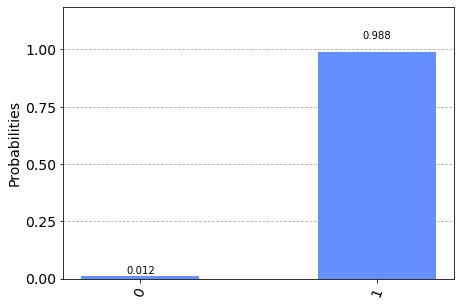

In [16]:
counts = job.result().get_counts()
plot_histogram(counts)

## Observation 1: The sequence XZXZ

Consider two consecutive pulses, $X_{\theta}^{(01)}$, with the phase offset $\phi$ between the pulses. Mathematically this is equivalent to a gate sequence of 

\begin{align}
&\exp\left(-i\dfrac{\phi}{2}\lambda_z^{(01)}\right)\cdot\exp\left(-i\dfrac{\theta}{2}\lambda_x^{(01)}\right)\cdot\exp\left(i\dfrac{\phi}{2}\lambda_z^{(01)}\right)\\
&=Z^{(01)}_{\phi}\cdot X_{\theta}^{(01)} \cdot Z^{(01)}_{-\phi}
\end{align}

We'd like to reproduce such sequence on a real schedule, using both two methods of *PhaseOffset* and *ShiftPhase*. 

Let us first create a schedule for a $X_{\theta}^{(01)}$ pulse.

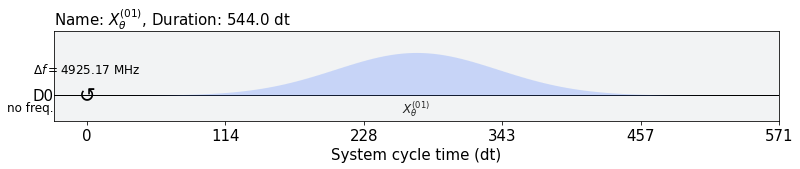

In [21]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\theta}^{(01)}$') as inst_xtheta01:
    drive_duration = d01_duration
    drive_sigma = d01_sigma
    pi_amp = d01_amplitude
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                                  amp=(theta/np.pi)*pi_amp,
                                  sigma=drive_sigma,
                                  name=r'$X_{\theta}^{(01)}$'), drive_chan)

inst_xtheta01.draw()

And a schedule for phase offset added of the $X_{\theta}^{(01)}$, called the inst_xtheta01_po

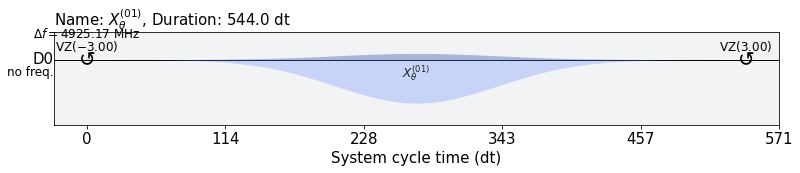

In [59]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\theta}^{(01)}$') as inst_z_xtheta01_z:
    drive_duration = d01_duration
    drive_sigma = d01_sigma
    pi_amp = d01_amplitude
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(3, drive_chan):
        pulse.play(pulse.Gaussian(duration=drive_duration,
                                      amp=(theta/np.pi)*pi_amp,
                                      sigma=drive_sigma,
                                      name=r'$X_{\theta}^{(01)}$'), drive_chan)

inst_z_xtheta01_z.draw()

How do they look like on complied circuit?

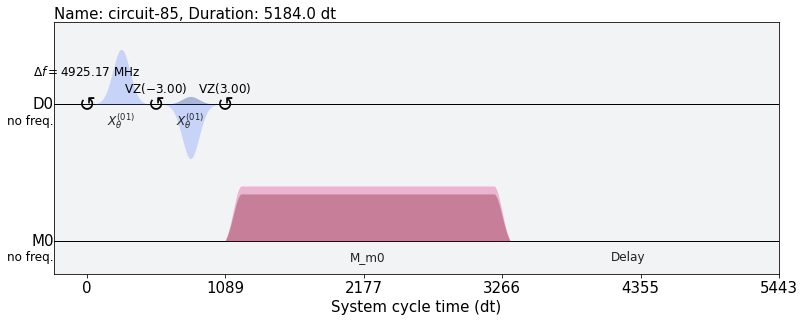

In [23]:
qc = QuantumCircuit(1,1)

xtheta01 = Gate('Xtheta01', 1, [])
xtheta01_po = Gate('Xtheta01_phaseoffset', 1, [])

qc.append(xtheta01, [0])
qc.append(xtheta01_po, [0])
qc.measure(0,0)

qc.add_calibration(xtheta01, (0,), inst_xtheta01, [])
qc.add_calibration(xtheta01_po, (0,), inst_xtheta01_po, [])

sched = schedule(qc, backend)
sched.draw()

As one should expected, the sequence of gate is nothing but $Z^{(01)}_{\phi}\cdot X_{\theta}^{(01)} \cdot Z^{(01)}_{-\phi}\cdot X_{\theta}^{(01)}$. 

Here comes the fun part. If we were to add another $Y^{(01)}_{\theta}$ gate, for example, what would happen? *D. McKay et al.* (PRA, 2017) shows that the gate sequence should look something like 

$Z^{(01)}_{-\phi}\cdot Y^{(01)}_{\theta}\cdot Z^{(01)}_{-\phi}\cdot Z^{(01)}_{\phi}\cdot X_{\theta}^{(01)} \cdot Z^{(01)}_{-\phi}\cdot X_{\theta}^{(01)}$

Let us try what method would allow us to obtain such sequence!

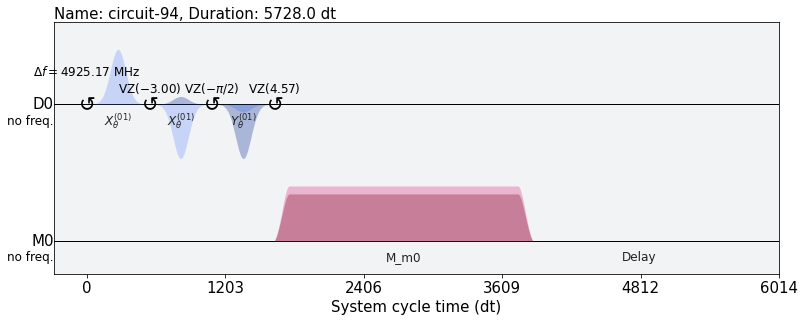

In [40]:
qc = QuantumCircuit(1,1)

xtheta01 = Gate('Xtheta01', 1, [])
xtheta01_po = Gate('Xtheta01_phaseoffset', 1, [])
ytheta01 = Gate('Ytheta01', 1, [])

qc.append(xtheta01, [0])
qc.append(xtheta01_po, [0])
qc.append(ytheta01, [0])
qc.measure(0,0)

qc.add_calibration(xtheta01, (0,), inst_xtheta01, [])
qc.add_calibration(ytheta01, (0,), inst_ytheta01, [])
qc.add_calibration(xtheta01_po, (0,), inst_xtheta01_po, [])

sched = schedule(qc, backend)
sched.draw()

The schedule indicates that the following $X_{\theta}^{(01)}$ is infact inact. Let us now consider the ShiftPhase method. 

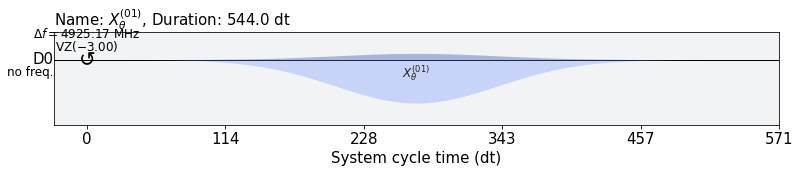

In [26]:
theta = 1
phi = 3

with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\theta}^{(01)}$') as inst_xtheta01_sp:
    drive_duration = d01_duration
    drive_sigma = d01_sigma
    pi_amp = d01_amplitude
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.shift_phase(phi, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                                  amp=(theta/np.pi)*pi_amp,
                                  sigma=drive_sigma,
                                  name=r'$X_{\theta}^{(01)}$'), drive_chan)

inst_xtheta01_sp.draw()

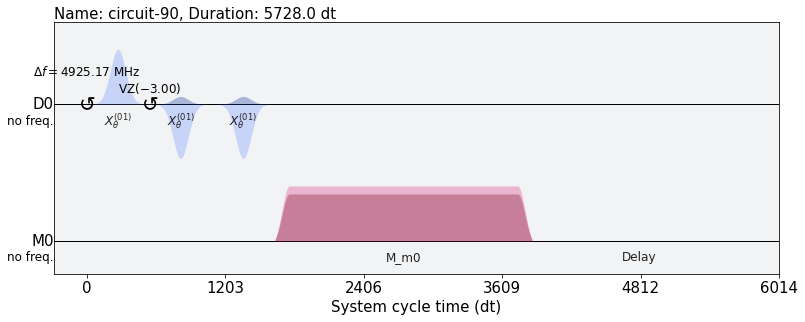

In [30]:
qc = QuantumCircuit(1,1)

xtheta01 = Gate('Xtheta01', 1, [])
xtheta01_sp = Gate('Xtheta01_shiftphase', 1, [])

qc.append(xtheta01, [0])
qc.append(xtheta01_sp, [0])
qc.append(ytheta01, [0])
qc.measure(0,0)

qc.add_calibration(xtheta01, (0,), inst_xtheta01, [])
qc.add_calibration(xtheta01_sp, (0,), inst_xtheta01_sp, [])

sched = schedule(qc, backend)
sched.draw()

## XYZYX

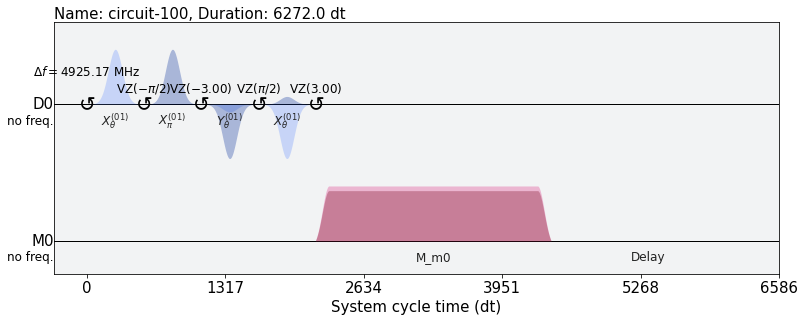

In [60]:
qc = QuantumCircuit(1,1)

xtheta01 = Gate('Xtheta01', 1, [])
ytheta01 = Gate('Ytheta01', 1, [])
z_ytheta01_z = Gate('z_Ytheta01_z', 1, [])
z_xtheta01_z = Gate('z_Xtheta01_z', 1, [])

qc.append(xtheta01, [0])
qc.append(ytheta01, [0])
qc.append(z_ytheta01_z, [0])
qc.append(z_xtheta01_z, [0])
qc.measure(0,0)

qc.add_calibration(xtheta01, (0,), inst_xtheta01, [])
qc.add_calibration(ytheta01, (0,), inst_ytheta01, [])
qc.add_calibration(z_ytheta01_z, (0,), inst_z_ytheta01_z, [])
qc.add_calibration(z_xtheta01_z, (0,), inst_z_xtheta01_z, [])

sched = schedule(qc, backend)
sched.draw()

# Hadamard $H_3$

In [ ]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'$X_{\theta}^{(01)}$') as inst_xtheta01_sp:
    drive_duration = d01_duration
    drive_sigma = d01_sigma
    pi_amp = d01_amplitude
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    pulse.shift_phase(phi, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                                  amp=(theta/np.pi)*pi_amp,
                                  sigma=drive_sigma,
                                  name=r'$X_{\theta}^{(01)}$'), drive_chan)

inst_xtheta01_sp.draw()

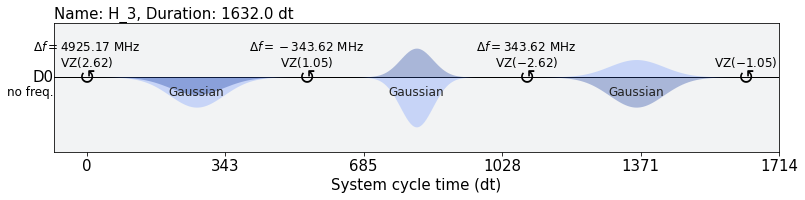

In [5]:
with pulse.build(backend=backend, default_alignment='sequential', name=r'H_3') as Hadamard:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(-2.61799, drive_chan):
        pulse.play(pulse.Gaussian(duration=d01_duration,
                                 amp=(1.5708/np.pi)*d01_amplitude,
                                 sigma=d01_sigma), drive_chan)
    pulse.set_frequency(f12, drive_chan)
    with pulse.phase_offset(-3.66519, drive_chan):
        pulse.play(pulse.Gaussian(duration=d12_duration,
                                 amp=(1.91063/np.pi)*d12_amplitude,
                                 sigma=d12_sigma), drive_chan)
    pulse.set_frequency(f01, drive_chan)
    with pulse.phase_offset(-1.0472, drive_chan):
        pulse.play(pulse.Gaussian(duration=d01_duration,
                                 amp=(1.5708/np.pi)*d01_amplitude,
                                 sigma=d01_sigma), drive_chan)
Hadamard.draw()

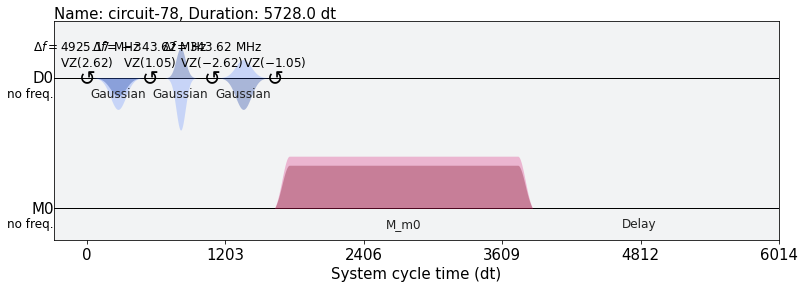

In [6]:
qc = QuantumCircuit(1,1)

H = Gate('Hadamard', 1, [])

qc.append(H, [0])
qc.measure(0,0)
qc.add_calibration(H, (0,), Hadamard, [])

sched = schedule(qc, backend)
sched.draw()

In [7]:
num_shots = 2**13

job = backend.run(qc, 
                  meas_level=2, 
                  meas_return='avg', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


account._job_result_object_storage:WARNING:2022-08-16 17:15:42,698: An error occurred while sending download completion acknowledgement: "HTTPSConnectionPool(host='api.quantum-computing.ibm.com', port=443): Read timed out. (read timeout=None)"


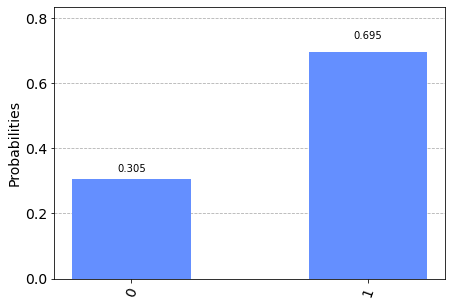

In [8]:
counts = job.result().get_counts()
plot_histogram(counts)

Which is correct?